In [356]:
#imports
import pandas as pd
import numpy as np

#API 
import requests

#Automating
import time
import datetime
import warnings
import sys

#sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.naive_bayes import MultinomialNB

> Test pull from world of PhotoshopBattles Subreddit
>
> Test pull from world of Creepy Subreddit

In [180]:
# Set base url
url= 'https://api.pushshift.io/reddit/search/submission/?subreddit='

In [181]:
# Set params
params= {
    'subreddit': 'photoshopbattles',
    'size'     : 50,
    'lang'     :True,
    'before'   :1601384439
}

In [182]:
# Make request
res= requests.get(url, params)
res

<Response [200]>

In [183]:
# Examine object
res.text

'{\n    "data": [\n        {\n            "all_awardings": [],\n            "allow_live_comments": false,\n            "author": "S4m0s",\n            "author_flair_css_class": null,\n            "author_flair_richtext": [],\n            "author_flair_text": null,\n            "author_flair_type": "text",\n            "author_fullname": "t2_11diws",\n            "author_patreon_flair": false,\n            "author_premium": false,\n            "awarders": [],\n            "can_mod_post": false,\n            "contest_mode": false,\n            "created_utc": 1601384087,\n            "domain": "i.redd.it",\n            "full_link": "https://www.reddit.com/r/photoshopbattles/comments/j1ynam/psbattle_this_clouds_over_a_city/",\n            "gildings": {},\n            "id": "j1ynam",\n            "is_crosspostable": true,\n            "is_meta": false,\n            "is_original_content": false,\n            "is_reddit_media_domain": true,\n            "is_robot_indexable": true,\n          

In [184]:
#Try as JSON?to transfer data as text like dictionary
res.json()


{'data': [{'all_awardings': [],
   'allow_live_comments': False,
   'author': 'S4m0s',
   'author_flair_css_class': None,
   'author_flair_richtext': [],
   'author_flair_text': None,
   'author_flair_type': 'text',
   'author_fullname': 't2_11diws',
   'author_patreon_flair': False,
   'author_premium': False,
   'awarders': [],
   'can_mod_post': False,
   'contest_mode': False,
   'created_utc': 1601384087,
   'domain': 'i.redd.it',
   'full_link': 'https://www.reddit.com/r/photoshopbattles/comments/j1ynam/psbattle_this_clouds_over_a_city/',
   'gildings': {},
   'id': 'j1ynam',
   'is_crosspostable': True,
   'is_meta': False,
   'is_original_content': False,
   'is_reddit_media_domain': True,
   'is_robot_indexable': True,
   'is_self': False,
   'is_video': False,
   'link_flair_background_color': '',
   'link_flair_css_class': 'daily',
   'link_flair_richtext': [{'e': 'text', 't': 'Battle'}],
   'link_flair_text': 'Battle',
   'link_flair_text_color': 'dark',
   'link_flair_type

In [185]:
#Make this to a DataFrame
df_photoshopbattles= pd.DataFrame(res.json()['data'])
df_photoshopbattles.head(3).T

,0,1,2
all_awardings,[],[],[]
allow_live_comments,False,False,False
author,S4m0s,Duchowicz,SuddieBuddie
author_flair_css_class,None,None,None
author_flair_richtext,[],[],[]
...,...,...,...
removed_by_category,NaN,automod_filtered,NaN
media,NaN,NaN,NaN
media_embed,NaN,NaN,NaN
secure_media,NaN,NaN,NaN


In [186]:
#print all the columns and cross-reference with document to identify columns that can be useful in webscraping
for column in df_photoshopbattles.columns:
    print (column)

all_awardings
allow_live_comments
author
author_flair_css_class
author_flair_richtext
author_flair_text
author_flair_type
author_fullname
author_patreon_flair
author_premium
awarders
can_mod_post
contest_mode
created_utc
domain
full_link
gildings
id
is_crosspostable
is_meta
is_original_content
is_reddit_media_domain
is_robot_indexable
is_self
is_video
link_flair_background_color
link_flair_css_class
link_flair_richtext
link_flair_text
link_flair_text_color
link_flair_type
locked
media_only
no_follow
num_comments
num_crossposts
over_18
parent_whitelist_status
permalink
pinned
post_hint
preview
pwls
retrieved_on
score
selftext
send_replies
spoiler
stickied
subreddit
subreddit_id
subreddit_subscribers
subreddit_type
thumbnail
thumbnail_height
thumbnail_width
title
total_awards_received
treatment_tags
upvote_ratio
url
url_overridden_by_dest
whitelist_status
wls
removed_by_category
media
media_embed
secure_media
secure_media_embed


In [187]:
#Extract columns:
df_photoshopbattles= df_photoshopbattles.loc[:, ['title',
                        'created_utc', 
                        'selftext',
                        'subreddit',
                        'id',
                        'media_only']]

df_photoshopbattles.head(3).T

,0,1,2
title,PsBattle: This clouds over a city,PsBattle: The statue of the pope with a rock,PsBattle: This dog hiding under a curtain.
created_utc,1601384087,1601384042,1601383540
selftext,,,
subreddit,photoshopbattles,photoshopbattles,photoshopbattles
id,j1ynam,j1ymuw,j1yi3z
media_only,False,False,False


### Build API Function

>Let's write a function (from BH 9-12 )to scale up the previous process to pull many posts, working iteratively backwards using epoch timestamp.

In [188]:
def get_comments(subreddit, n_iter, epoch_right_now): # subreddit name and number of times function should run
    # store base url variable
    base_url = 'https://api.pushshift.io/reddit/search/submission/?subreddit='
    
    # instantiate empty list    
    df_list = []
    
    # save current epoch, used to iterate in reverse through time
    current_time = epoch_right_now
    
    # set up for loop
    for post in range(n_iter):
        
        # instantiate get request
        res = requests.get(
            
            # requests.get takes base_url and params
            base_url,
            # parameters for get request
            params={
                
                # specify subreddit
                "subreddit": subreddit,
                
                # specify number of posts to pull
                "size": 100,   
                
                # ???
                "lang": True,
                
                # pull everything from current time backward
                "before": current_time
            }
        )
        
        # take data from most recent request, store as df
        df = pd.DataFrame(res.json()['data'])
        
        # pull specific columns from dataframe for analysis
        df = df.loc[:, ['title',
                        'created_utc', 
                        'selftext',
                        'subreddit',
                        'id',
                        'media_only']]
        
        # append to empty dataframe list
        df_list.append(df)
        
        # set current time counter back to last epoch in recently grabbed df
        current_time = df['created_utc'].min()

    # return one dataframe for all requests
    return pd.concat(df_list, axis=0)

# Adapated from Tim Book's Lesson Example


> Use function on Photoshopbattles subreddits

In [189]:
#photoshopbattles= get_comments('photoshopbattles', 10, 1601756663)
#photoshopbattles

> Use function on Creepy subreddits

In [190]:
#creepy= get_comments('creepy', 10, 1601756663)
#creepy

> Combining the DataFrames

In [191]:
photoshopbattles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 962 entries, 0 to 99
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        962 non-null    object
 1   created_utc  962 non-null    int64 
 2   selftext     962 non-null    object
 3   subreddit    962 non-null    object
 4   id           962 non-null    object
 5   media_only   962 non-null    bool  
 6   is_creepy    962 non-null    int64 
dtypes: bool(1), int64(2), object(4)
memory usage: 53.5+ KB


In [192]:
creepy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 881 entries, 0 to 99
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        881 non-null    object
 1   created_utc  881 non-null    int64 
 2   selftext     881 non-null    object
 3   subreddit    881 non-null    object
 4   id           881 non-null    object
 5   media_only   881 non-null    bool  
 6   is_creepy    881 non-null    int64 
dtypes: bool(1), int64(2), object(4)
memory usage: 49.0+ KB


In [193]:
# #Explore each of the data frames, drop duplicants and export into a csv file 
# photoshopbattles.drop_duplicates(subset='title', inplace=True)

# creepy.drop_duplicates(subset='title', inplace=True)

# photoshopbattles.to_csv('../project-3/CSV files/reddit_psb.csv')

# creepy.to_csv('../project-3/CSV files/reddit_creepy.csv')

In [194]:
creepy.shape

(881, 7)

In [195]:
photoshopbattles.shape

(962, 7)

### Exploring the datasets
>Let's create features from the thread titles and descriptions.
>
>Creating the dataframe and the target vector
>
>Where y=1, the post is from subreddit Creepy

In [196]:
# creating the target value
photoshopbattles['is_creepy']=0
creepy['is_creepy']=1

In [197]:
#Merging two dataframes

df=photoshopbattles.append(creepy, sort=True)
df

,created_utc,id,is_creepy,media_only,selftext,subreddit,title
0,1601756284,j4lz6q,0,False,,photoshopbattles,Make this into anything pls Thank you
1,1601755062,j4ln4v,0,False,,photoshopbattles,If u know this girl leave a like
2,1601754807,j4lkhe,0,False,,photoshopbattles,PsBattle: This 16th Century Fireplace
3,1601754648,j4livq,0,False,,photoshopbattles,PsBattle: A rabbit who is taming a dog!
4,1601754566,j4li3u,0,False,,photoshopbattles,PsBattle: A (my) rabbit who is taming a dog!
...,...,...,...,...,...,...,...
95,1600861055,iy8fea,1,False,,creepy,Slime dog
96,1600858687,iy7xln,1,False,,creepy,I drew this random line thing (second picture)...
97,1600858367,iy7vbx,1,False,,creepy,I drew this random line work thing (2nd pictur...
98,1600854986,iy783c,1,False,,creepy,"Opiate, by Me"


In [198]:
#Getting 3 columns of id and is_creepy and title and making id is the index column
df= df[['is_creepy', 'title', 'id']]
df.set_index('id', inplace=True)
df

,is_creepy,title
id,,
j4lz6q,0,Make this into anything pls Thank you
j4ln4v,0,If u know this girl leave a like
j4lkhe,0,PsBattle: This 16th Century Fireplace
j4livq,0,PsBattle: A rabbit who is taming a dog!
j4li3u,0,PsBattle: A (my) rabbit who is taming a dog!
...,...,...
iy8fea,1,Slime dog
iy7xln,1,I drew this random line thing (second picture)...
iy7vbx,1,I drew this random line work thing (2nd pictur...


In [199]:
df.isnull().sum()

is_creepy    0
title        0
dtype: int64

In [201]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
is_creepy,1843.0,0.478025,0.499652,0.0,0.0,0.0,1.0,1.0


In [211]:
df['is_creepy'].nunique()

2

### Word/Tag Cloud
>
>Tags are usually single words, and the importance of each tag is shown with font size or color.

In [121]:
#https://peekaboo-vision.blogspot.com/2012/11/a-wordcloud-in-python.html
from wordcloud import WordCloud, get_single_color_func, ImageColorGenerator, STOPWORDS
stopwords= set(STOPWORDS)

def show_wordcloud(data, title=None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=400,
        max_font_size=40, 
        scale=5,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=3)

    plt.imshow(wordcloud)
    plt.show()

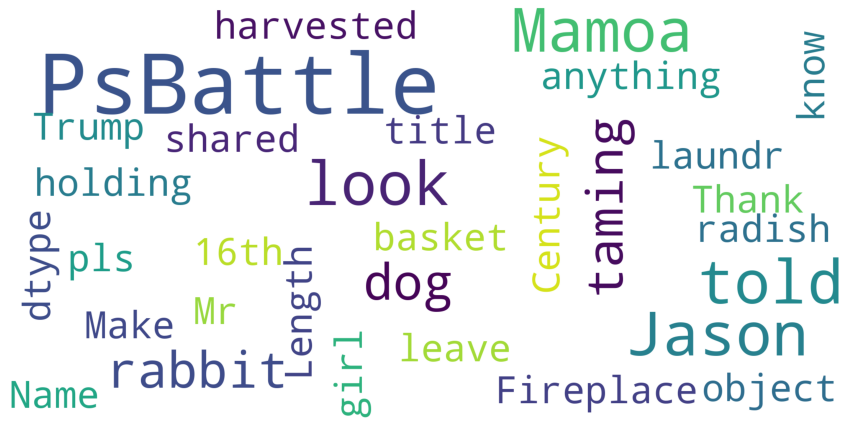

In [122]:
import matplotlib.pyplot as plt
show_wordcloud(photoshopbattles['title'])

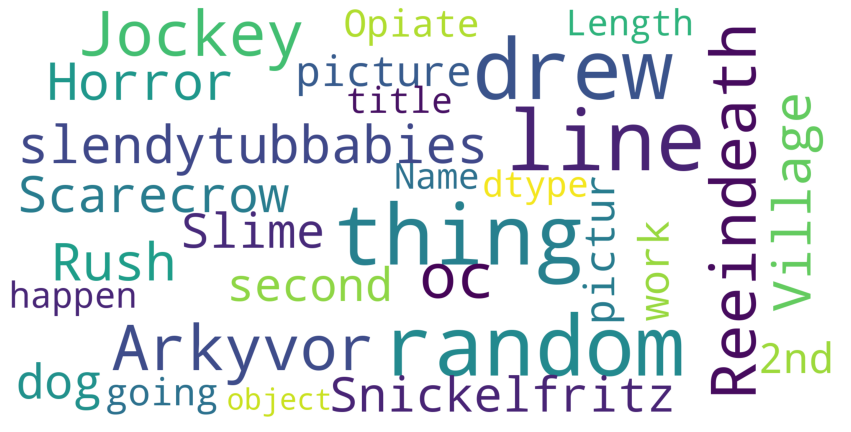

In [123]:
#let's get the word cloud for creepy df
show_wordcloud(creepy['title'])

### Modeling Data
>Train/Test split

In [419]:
X=df['title']
y=df['is_creepy']

In [420]:
# checking balance of data and baseline accuracy
#the results seems like the data set in balanced and Photoshopbattles is the dominant clas %52.
df['is_creepy'].value_counts(normalize=True)

0    0.521975
1    0.478025
Name: is_creepy, dtype: float64

In [421]:
X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=28, stratify=y)

In [422]:
X_train.shape

(1382,)

In [423]:
y_train.shape

(1382,)

### EDA 
> Fitting a count vectorizer to find the most popular words


In [229]:
cvec=CountVectorizer(
        analyzer='word',
        tokenizer=None,
        preprocessor= None,
        stop_words='english')

X_train_cvec=cvec.fit_transform(X_train)
X_test_cvec=cvec.transform(X_test)
X_train_cvec

<1382x2583 sparse matrix of type '<class 'numpy.int64'>'
	with 6044 stored elements in Compressed Sparse Row format>

In [230]:
cvec_df= pd.DataFrame(X_train_cvec.todense(),
                     columns=cvec.get_feature_names())

cvec_df

,02,03,09,093,09444444444444,096,10,100,1000,109,...,الدينية,المعتقدات,لحوم,من,ℜ𝔞𝔯𝔢𝔟𝔦𝔷𝔞𝔯𝔯𝔢,に凸撃する,ホラー,人形の集落,奥播磨,𝔒𝔫𝔩𝔶𝔉𝔞𝔫𝔰
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1378,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1379,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1380,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### let's plot the most common words for each dataframe:
>
>Plot for Creepy df words

In [235]:
columns=cvec.get_feature_names()
columns

['02',
 '03',
 '09',
 '093',
 '09444444444444',
 '096',
 '10',
 '100',
 '1000',
 '109',
 '12',
 '13',
 '14',
 '15',
 '16',
 '1800s',
 '1878',
 '18th',
 '19',
 '1910',
 '1920s',
 '1997',
 '1st',
 '20',
 '200',
 '2005',
 '2008',
 '2010',
 '2014',
 '2015',
 '2016',
 '2020',
 '24',
 '2450ft',
 '25',
 '27',
 '3000',
 '3157',
 '36',
 '3d',
 '427',
 '428',
 '4am',
 '51',
 '60',
 '666',
 '6ft',
 '6yr',
 '70',
 '8bithardproductions',
 '90s',
 '96th',
 '99',
 'aaronsimscompany',
 'abandoned',
 'abdullah',
 'able',
 'abomination',
 'absoluteunits',
 'absurdly',
 'accept',
 'account',
 'accounts',
 'acid',
 'acrylic',
 'acrylics',
 'act',
 'acting',
 'action',
 'actual',
 'ad',
 'adam',
 'adams',
 'add',
 'adenine',
 'adjuster',
 'adlicio',
 'administration',
 'admittedly',
 'ads',
 'advertisement',
 'advice',
 'af',
 'afl',
 'afraid',
 'afro',
 'ago',
 'agreement',
 'ahead',
 'ai',
 'aimed',
 'air',
 'airport',
 'ais',
 'ak',
 'akvarista11',
 'alex',
 'alien',
 'alive',
 'alleyway',
 'allowed',
 

In [239]:
X_train_cvec.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [283]:
X_train_cvec

<1382x2583 sparse matrix of type '<class 'numpy.int64'>'
	with 6044 stored elements in Compressed Sparse Row format>

In [264]:
y_train

id
j34sm9    0
j0jznr    1
j155zh    1
j271v5    0
j4dm7o    1
         ..
j44vqk    0
j3assj    0
izw8di    1
j1ti2b    1
j2zrko    0
Name: is_creepy, Length: 1382, dtype: int64

In [281]:
creepy_vect

,02,03,09,093,09444444444444,096,10,100,1000,109,...,الدينية,المعتقدات,لحوم,من,ℜ𝔞𝔯𝔢𝔟𝔦𝔷𝔞𝔯𝔯𝔢,に凸撃する,ホラー,人形の集落,奥播磨,𝔒𝔫𝔩𝔶𝔉𝔞𝔫𝔰
is_creepy,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [287]:
X_train

id
j34sm9        This duck looking cloud, credit u/akvarista11
j0jznr    Theseus, a juvenile King Snake, who sheltered ...
j155zh    I had a dream I saw a skinwalker, it looked so...
j271v5                     Do something with this... thing?
j4dm7o                I don't know but this is creepy to me
                                ...                        
j44vqk                                        PsBattle paws
j3assj               PsBattle: My dog sleeping on the floor
izw8di                            A Jaw Dropping Livestream
j1ti2b                                                frogs
j2zrko                                Psbattles: long remmy
Name: title, Length: 1382, dtype: object

In [288]:
creepy_vect=pd.DataFrame(X_train_cvec.todense(),
                        columns=cvec.get_feature_names(), index=X_train.index).reindex(y_train[y_train == 1].index)
top_creepy_words= creepy_vect.mean().sort_values(ascending=False).iloc[:10]
top_creepy_words.values

array([0.09833585, 0.04689864, 0.0408472 , 0.03479576, 0.02723147,
       0.02571861, 0.02420575, 0.02118003, 0.02118003, 0.01966717])

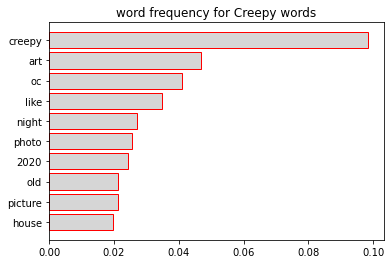

In [289]:
top_creepy_words=top_creepy_words.sort_values(ascending=True)
plt.barh(top_creepy_words.index, top_creepy_words.values, color=(0.2, 0.2, 0.2, 0.2),  edgecolor='Red')
plt.title('word frequency for Creepy words');

>Plot for Photoshopbattles df words

In [296]:
psb_vect=pd.DataFrame(X_train_cvec.todense(),
                        columns=cvec.get_feature_names(), index=X_train.index).reindex(y_train[y_train == 0].index)
top_psb_words= psb_vect.mean().sort_values(ascending=False).iloc[:10]
top_psb_words.values

array([0.6962552 , 0.10402219, 0.07489598, 0.03606103, 0.03190014,
       0.03190014, 0.02496533, 0.0221914 , 0.02080444, 0.01803051])

In [297]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

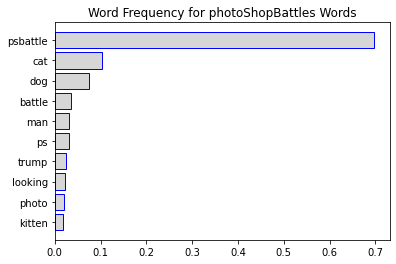

In [403]:
top_psb_words=top_psb_words.sort_values(ascending=True)
plt.barh(top_psb_words.index, top_psb_words.values, color=(0.2, 0.2, 0.2, 0.2),  edgecolor='Blue')
plt.title('Word Frequency for photoShopBattles Words');

### Let's fit the model!
>Using Logistic Regression, Random Forest, TF-IDF and GridSearchCV

### TF-IDF Model (term frequency–inverse document frequency)


In [299]:
#Instantiating and fitting the TF-IDF model
tvec= TfidfVectorizer(analyzer='word',
                     tokenizer=None,
                     preprocessor=None,
                     stop_words='english')

X_train_tvec=tvec.fit_transform(X_train)
X_test_tvec=tvec.transform(X_test)
X_train_tvec

<1382x2583 sparse matrix of type '<class 'numpy.float64'>'
	with 6044 stored elements in Compressed Sparse Row format>

In [300]:
tvec_df= pd.DataFrame(X_train_tvec.todense(),
                     columns=tvec.get_feature_names())

tvec_df.head()

,02,03,09,093,09444444444444,096,10,100,1000,109,...,الدينية,المعتقدات,لحوم,من,ℜ𝔞𝔯𝔢𝔟𝔦𝔷𝔞𝔯𝔯𝔢,に凸撃する,ホラー,人形の集落,奥播磨,𝔒𝔫𝔩𝔶𝔉𝔞𝔫𝔰
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1- Bayes Classifier Model

In [382]:
#Initiating and fitting the bayes model
nbayes=MultinomialNB()
pipe=make_pipeline(tvec, nbayes)
pipe

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(stop_words='english')),
                ('multinomialnb', MultinomialNB())])

In [383]:
params={
       'tfidfvectorizer__max_features': [2000, 3000, 4000, 5000], 
          'tfidfvectorizer__stop_words': ['english', None],
         'tfidfvectorizer__ngram_range': [(1, 2), (1, 1)]
    
}

In [384]:
#grid
grid=GridSearchCV(pipe, param_grid=params)

In [386]:
#fit it
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words='english')),
                                       ('multinomialnb', MultinomialNB())]),
             param_grid={'tfidfvectorizer__max_features': [2000, 3000, 4000,
                                                           5000],
                         'tfidfvectorizer__ngram_range': [(1, 2), (1, 1)],
                         'tfidfvectorizer__stop_words': ['english', None]})

In [387]:
# Score model on training set.
grid.score(X_train, y_train)

0.9392185238784371

In [388]:
# Score model on testing set.
grid.score(X_test, y_test)

0.8611713665943601

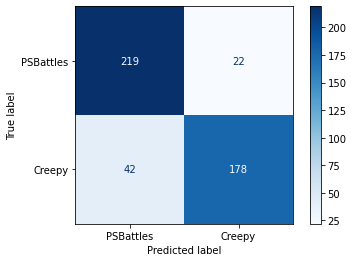

In [401]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
# Get predictions
preds = grid.predict(X_test)
# Save confusion matrix values
cmat2 = confusion_matrix(y_test, preds)
plot_confusion_matrix(grid,  X_test, y_test,cmap='Blues', display_labels=['PSBattles', 'Creepy']);

### In my Bayes Classifier, the model has been overfitted on training data set !

### 2- Random Forest Classifier Model

In [314]:
#Instantiating and fitting the Ranfom Forest Classifier model
rfc=RandomForestClassifier()

params={
    'n_estimators': [50, 100, 150, 200],
    
}

rfc_gs=GridSearchCV(estimator=rfc,
                   param_grid=params,
                   cv=5,
                   verbose=1,
                   n_jobs=-1)

rfc_gs= rfc_gs.fit(X_train_tvec, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    2.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.3s finished


In [315]:
print(f'Random Forest GridSearchCV Best Score:{rfc_gs.best_score_}')
print(f'Random Forest GridSearchCV Best Parameters:{rfc_gs.best_params_}')

Random Forest GridSearchCV Best Score:0.8856903678124837
Random Forest GridSearchCV Best Parameters:{'n_estimators': 150}


In [318]:
rfc_gs.best_estimator_.feature_importances_

array([1.85059829e-05, 8.37334411e-05, 7.03074675e-07, ...,
       3.68689623e-07, 1.32851460e-05, 6.86587678e-05])

In [324]:
# Let's find the importance for each word
word_importance=zip(tvec.get_feature_names(), rfc_gs.best_estimator_.feature_importances_);
sorted(word_importance, key=lambda x: abs(x[1]), reverse=True)


[('psbattle', 0.34850766954308987),
 ('cat', 0.02879902677299529),
 ('creepy', 0.021806069806259598),
 ('dog', 0.01977099531053449),
 ('battle', 0.011674447558454829),
 ('oc', 0.00969739309135673),
 ('ps', 0.008111944305378182),
 ('art', 0.007724396446635029),
 ('man', 0.006204809341484474),
 ('kitten', 0.005995319385860637),
 ('trump', 0.005988081161292435),
 ('make', 0.005914839379203834),
 ('photoshop', 0.005258807632843278),
 ('psbattles', 0.004943460977266919),
 ('looking', 0.0044777409374073315),
 ('night', 0.004330506894852917),
 ('drawing', 0.003617014817481962),
 ('thing', 0.003494756789751467),
 ('video', 0.0034874007211758993),
 ('staring', 0.0032367774233218595),
 ('want', 0.0030980034139764198),
 ('horror', 0.003069098364924502),
 ('photo', 0.0030410675846862375),
 ('holding', 0.0027644049373349387),
 ('kid', 0.0027207910510343675),
 ('abandoned', 0.0027032906577955863),
 ('happy', 0.0026740831049587815),
 ('eating', 0.0026602432943081595),
 ('2020', 0.0026484121616094695)

In [434]:
predict=rfc_gs.predict(X_test_tvec)
rfc_gs.score(X_test_tvec, y_test)

0.8698481561822126

In [441]:
predict

array([0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1,

### The Random Forest Model has the training score of %88 and testing score of %87.

### 3- Logistic Regression Model

In [334]:
#instantiating and fitting logistic regression
lr=LogisticRegression()
lr.fit(X_train_tvec, y_train)

LogisticRegression()

In [407]:
lr.score(X_train_tvec, y_train)

0.9363241678726484

In [408]:
cross_val_score(lr, X_train_tvec, y_train, cv=5).mean()

0.8791843248051064

In [409]:
lr.score(X_test_tvec, y_test)

0.8806941431670282

In [340]:
print(f'Logistic Regression Intercept: {lr.intercept_}')
print(f'Logistic Regression Coefficient: {lr.coef_}')

Logistic Regression Intercept: [0.62643214]
Logistic Regression Coefficient: [[ 0.14267872 -0.00551727  0.06076684 ...  0.06832579  0.06832579
   0.202528  ]]


In [341]:
X_df=pd.DataFrame(X_train_tvec.sum(), index=tvec.get_feature_names(), columns=['count'])

In [342]:
X_df['coef']=lr.coef_.T

In [343]:
X_df.isnull().sum()

count    0
coef     0
dtype: int64

In [344]:
top_10_coef=X_df.sort_values(by=['coef'], ascending=False).head(10)
top_10_coef

,count,coef
creepy,2641.553755,2.574350
oc,2641.553755,1.714744
art,2641.553755,1.443898
drawing,2641.553755,0.962006
abandoned,2641.553755,0.913614
horror,2641.553755,0.881842
video,2641.553755,0.873182
drew,2641.553755,0.794873
artwork,2641.553755,0.780584
digital,2641.553755,0.741946


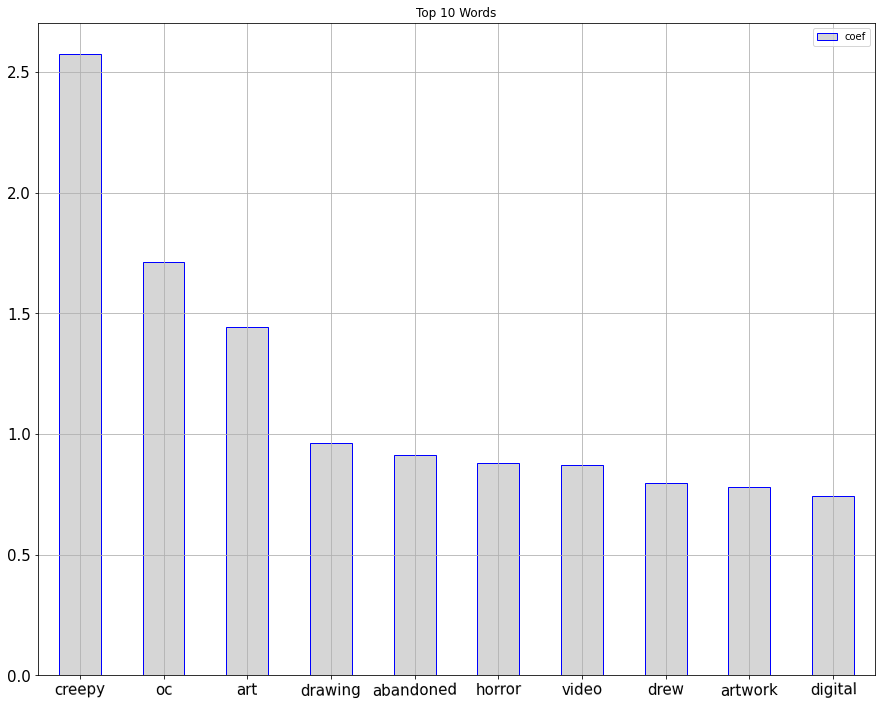

In [406]:
top_10_coef['coef'].plot.bar(
                        rot = 1, 
                        figsize=(15,12),
                        grid=True,
                        legend=True,
                        fontsize=15,
                        title="Top 10 Words",
                        color=(0.2, 0.2, 0.2, 0.2),  
                        edgecolor='Blue');

### The Logistic Regression Model has done a better job on training and testing data sets.

In [429]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

pipe.fit(X_train, y_train)

# Evaluate how your model will perform on unseen data
print(f' Cross_val_score is: {cross_val_score(pipe, X_train, y_train, cv=3).mean()}') 
# Training score
print(f' Training Score is: {pipe.score(X_train, y_train)}')
# Test score
print(f' Test Score is: {pipe.score(X_test, y_test)}')

 Cross_val_score is: 0.8950941557420856
 Training Score is: 0.9457308248914617
 Test Score is: 0.911062906724512


In [430]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

pipe.fit(X_train, y_train)

# Evaluate how your model will perform on unseen data
print(f' Cross_val_score is: {cross_val_score(pipe, X_train, y_train, cv=3).mean()}') 
# Training score
print(f' Training Score is: {pipe.score(X_train, y_train)}')
# Test score
print(f' Test Score is: {pipe.score(X_test, y_test)}')

 Cross_val_score is: 0.8922050363104782
 Training Score is: 0.9710564399421129
 Test Score is: 0.8893709327548807


In [431]:
pipe_params = {
    'cvec__max_features': [2500, 3000, 3500, 10_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.8893064855858404


{'cvec__max_df': 0.9,
 'cvec__max_features': 2500,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2)}

In [433]:
print(f'GridSearchCV score on Training Dataset :{gs.score(X_train, y_train)}')
print(f'GridSearchCV score on Testing Dataset :{gs.score(X_test, y_test)}')

GridSearchCV score on Training Dataset :0.9486251808972503
GridSearchCV score on Testing Dataset :0.8893709327548807
